# Comparing RNN models on financial data


In [ ]:
### Pour utiliser sur google colab

import os

from google.colab import drive
drive.mount('drive')

!mkdir -p drive -v
#!google-drive-ocamlfuse drive

cwd = os.getcwd()

#### Changez le chemin ci-dessous vers votre repertoire dans votre googledrive
##############################################################################

monchemin = '/content/drive/MyDrive/Colab Notebooks/DL'

dir_path  = os.path.join(cwd, monchemin)
dirs = os.listdir(dir_path)
os.chdir(dir_path)

###  

Mounted at drive


In [ ]:

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Getting the data

In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [ ]:
# First, we get the data
dataset = pd.read_csv('stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
# Checking for missing values
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

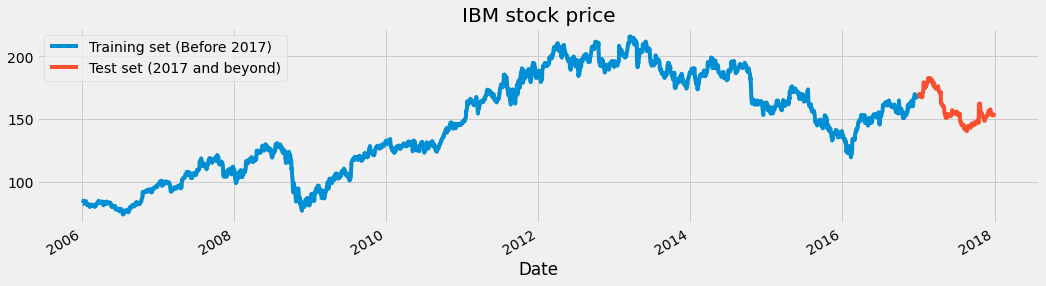

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
print (X_train.shape)

(2709, 60, 1)


# Experimental comparison

1. Perform learning and plot the predictions of a few learned models   

2. Extensive comparison

Compare SimpleRNN, GRU NNs, LSTM NNs in terms of performance (mse) vs number of parameters for a variery of models while tryoing to get the best performance for a given budget measured as the number of parameters.

Can you find a clear ranking of the three families of models ? 

3. Can these models be trained to perform prediction at a longer range ? For instance predicting the values of one full week ahead (the next 7 days) instead of predicting the value for the next only ?  
- Implement and test a strategy for testting one step ahead prediction for longer range prediction.
- Design implement and test a model for  learning such a long term prediction task.
     
     

#1. Perform learning and plot the predictions of a few learned models 

Le choix du nombre de couches et du nombres de neuronnes de ces couches ont été choisi après lecture de cet article : https://www.heatonresearch.com/2017/06/01/hidden-layers.html

In [ ]:
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN

In [ ]:
######## Test Dataset ########
y_true = dataset['2017':].iloc[:,1:2].values
test_set = np.concatenate((training_set[-60:],y_true))

sc = MinMaxScaler(feature_range=(0,1))
test_set_scaled = sc.fit_transform(test_set)

X_test = []
y_test = []
for i in range(60,311):
    X_test.append(test_set_scaled[i-60:i,0])
    y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

##SimpleRNN


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 60, 48)            2400      
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 8)                 456       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,865
Trainable params: 2,865
Non-trainable params: 0
_________________________________________________________________


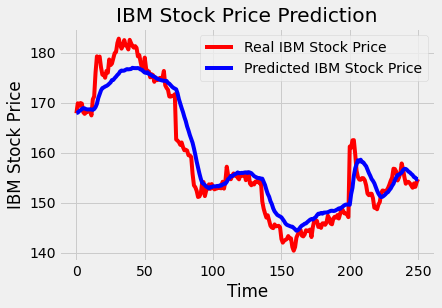

In [ ]:
simpleRnn = Sequential()
simpleRnn.add(SimpleRNN(48,dropout=0, return_sequences=True, input_shape=(60,1)))
simpleRnn.add(SimpleRNN(8,dropout=0))
simpleRnn.add(Dense(1))
simpleRnn.compile(optimizer='rmsprop',loss='mean_squared_error')

simpleRnn.fit(X_train,y_train,epochs=10,batch_size=64,verbose=0)
simpleRnn.summary()

y_pred_sc = simpleRnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred_sc)
plot_predictions(y_true, y_pred)

##GRU NNs

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 60, 48)            7344      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 1392      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 8,745
Trainable params: 8,745
Non-trainable params: 0
_________________________________________________________________


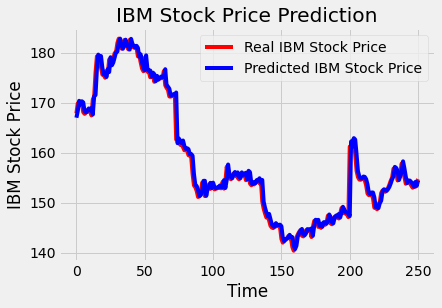

In [ ]:
GRUnn = Sequential()
GRUnn.add(GRU(48,dropout=0, return_sequences=True, input_shape=(60,1)))
GRUnn.add(GRU(8,dropout=0))
GRUnn.add(Dense(1))
GRUnn.compile(optimizer='rmsprop',loss='mean_squared_error')

GRUnn.fit(X_train,y_train,epochs=50,batch_size=64,verbose=0)
GRUnn.summary()

y_pred_sc = GRUnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred_sc)
plot_predictions(y_true, y_pred)

## LSTM NNs

In [ ]:
LSTMnn = Sequential()
LSTMnn.add(LSTM(64,dropout=0, return_sequences=True, input_shape=(60,1)))
LSTMnn.add(LSTM(32,dropout=0))
LSTMnn.add(Dense(1))
LSTMnn.compile(optimizer='rmsprop',loss='mean_squared_error')

LSTMnn.fit(X_train,y_train,epochs=5,batch_size=64,verbose=0)
LSTMnn.summary()

y_pred_sc = LSTMnn.predict(X_test)
y_pred = sc.inverse_transform(y_pred_sc)
plot_predictions(y_true, y_pred)

In [ ]:
LSTMnn.count_params()

29345

#2. Extensive comparison

In [ ]:
###### Créer un réseau en fonction du model et du nombre de neurones #######
# Renvoie son MSE par rapport au set de test et le nombre de paramètres

from sklearn.metrics import mean_squared_error

def predModelX(model, neurones):
    NN = Sequential()
    NN.add(model(neurones, return_sequences=True, input_shape=(60,1)))
    NN.add(model(int(neurones/4)))
    NN.add(Dense(1))
    NN.compile(optimizer='rmsprop',loss='mean_squared_error')

    NN.fit(X_train,y_train,epochs=50,batch_size=64,verbose=0)

    y_pred_sc = NN.predict(X_test)
    y_pred = sc.inverse_transform(y_pred_sc)

    MSE = mean_squared_error(y_true, y_pred)
    return MSE, NN.count_params()

In [ ]:

import numpy as np
Neurones = np.arange(10,101,10)
Mse = np.array([])
Param = np.array([])
for i in Neurones:
    mse, param = predModelX(SimpleRNN,i)
    Mse = np.append(Mse,mse)
    Param = np.append(Param,param)

In [ ]:
Neurones = np.arange(10,101,10)
MseGRU = np.array([])
ParamGRU = np.array([])
for i in Neurones:
    mse, param = predModelX(GRU,i)
    MseGRU = np.append(MseGRU,mse)
    ParamGRU = np.append(ParamGRU,param)

In [ ]:
Neurones = np.arange(10,101,10)
MseLSTM = np.array([])
ParamLSTM = np.array([])
for i in Neurones:
    mse, param = predModelX(LSTM,i)
    MseLSTM = np.append(MseLSTM,mse)
    ParamLSTM = np.append(ParamLSTM,param)



[  587.  2286.  4912.  8771. 13437. 19456. 26162. 34341. 43087. 53426.]


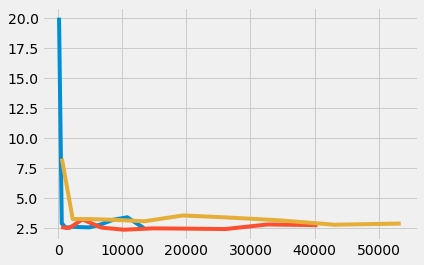

In [ ]:
plt.plot(Param, Mse, label="Simple RNN")
plt.plot(ParamGRU, MseGRU, label="GRU NN")
plt.plot(ParamLSTM, MseLSTM, label="LSTM NN")

On remarque que l'augmentation excessive du nombre de paramètres à calculer ne résulate pas à un meilleur MSE. On obtient de très bons résultats avec un petit nombre d'entre eux, bien qu'il faut qu'ils restent suffisant.

Si l'on se fie au minimum local de chaque courbe où le nombre de paramètre est minimum, on trouve :

    - 1er : LSTM
    - 2ème : Simple RNN
    - 3ème : GRU NN

# 3. Can these models be trained to perform prediction at a longer range ?

In [ ]:
simpleRnn = Sequential()
simpleRnn.add(SimpleRNN(48,dropout=0, return_sequences=True, input_shape=(60,1)))
simpleRnn.add(SimpleRNN(8,dropout=0))
simpleRnn.add(Dense(1))
simpleRnn.compile(optimizer='rmsprop',loss='mean_squared_error')

simpleRnn.fit(X_train,y_train,epochs=10,batch_size=64,verbose=0)

1.741952775583999


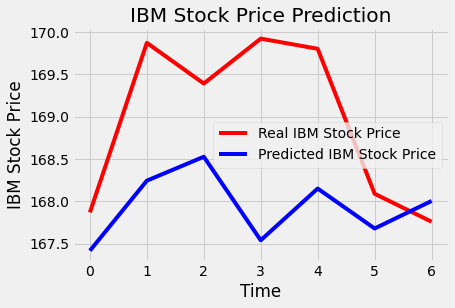

In [ ]:
previous_x = X_test[:1]

predicted = []

while len(predicted) < 7 :
    predicted.append(simpleRnn.predict(previous_x))
    previous_x = np.concatenate((previous_x,np.array([[[predicted[0][0][0]]]])),axis=1)

y_pred = sc.inverse_transform(X= np.concatenate(predicted))
mse = mean_squared_error(y_true[:7],y_pred)

print(mse)
plot_predictions(y_true[:7], y_pred)

La courbe n'est pas aberrante mais est bien moins précise. En effet il est plus difficile de prédire un élément lorsqu'il se trouve plus loin dans le futur.